# GAME OF THRONES Death Prediction

## Model Analysis

This sript will retrieve information from the .csv file saved on step 1 ([Load&Clean data](01_LoadClean_data.ipynb)) and genertate different Prediction Models on the data, both books and books+show information, to find the best fit.

If step 0 ([Load&Clean data](01_LoadClean_data.ipynb)) has already been executed **once** it will not be necessary to execute it again and you can start from here.

In [178]:
#Library Section
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle

from collections import Counter
from sklearn import model_selection
from sklearn import svm
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.learning_curve import learning_curve
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import precision_recall_curve
#from imblearn.over_sampling import SMOTE 

**Graphic Functions**

In [179]:
def plot_confussion_matrix(title,model,xtrain,ytrain, xtest, ytest):

    # accuracy for test & train:
    train_acc=model.score(xtrain, ytrain)
    test_acc=model.score(xtest,ytest)
    print("Training Data Accuracy: %0.2f" %(train_acc))
    print("Test Data Accuracy:     %0.2f" %(test_acc))
    
    y_true = ytest
    y_pred = model.predict(xtest)


    conf = confusion_matrix(y_true, y_pred)
    print(conf)

    print ('\n')
    print ("Precision:              %0.2f" %(conf[1, 1] / (conf[1, 1] + conf[0, 1])))
    print ("Recall:                 %0.2f"% (conf[1, 1] / (conf[1, 1] + conf[1, 0])))
    
    cm=confusion_matrix(y_true, y_pred)
    
    plt.figure()
    plt.imshow(cm, interpolation='nearest',cmap=plt.cm.Reds)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [180]:
def plot_roc_curve(model, x_test, y_test):
    y_score=model.predict_proba(x_test)[:,1]

    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)

    plt.figure()
    # Plotting our Baseline..
    plt.plot([0,1],[0,1])
    plt.plot(fpr,tpr,color='green')
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC Curve (AUC = ' + str(roc_auc)+ ')')

In [181]:
def plot_precition_recall(model, x_test, y_test) :
    y_score = model.predict_proba(x_test)[:,1]
    p,r,t = precision_recall_curve(y_test,y_score)

    # adding last threshold of '1' to threshold list
    t=np.vstack([t.reshape([-1,1]),1])

    plt.title('Precision Recall Curve')
    plt.plot(t,p, label='Precision')
    plt.plot(t,r, label='Recall')
    plt.legend()
    plt.grid()


## Analysis on INNER JOIN
**Characters that appear both in the Book and in the Tv Show**

In [182]:
got_df = pd.read_csv('csv/SQLINNER_GOT_data.csv')
len(got_df)

115

**Sacar los personajes que estan vivos y no han cambiado, o si no el modelo seguirá diciendo que están vivos...**

In [183]:
deads6_list = ['Grenn', 'Janos Slynt', 'Doreah', 'Mace Tyrell', 'Brynden Tully', 'Xaro Xhoan Daxos', 'Kevan Lannister']
got_df['isdead_shw'][got_df['name_x'].isin(deads6_list)] = 1

alive_list = ['Cersei Lannister', 'Tyrion Lannister', 'Daenerys Targaryen', 'Arya Stark', 'Jorah Mormont', 
              #'Jon Snow', 'Brienne of Tarth', 'Bronn', #Estos registros sí cambiaron en S7
              'Sansa Stark', 'Jaime Lannister', 'Samwell Tarly', 'Sandor Clegane', 'Varys', 'Brandon Stark',
              'Theon Greyjoy', 'Podrick Payne', 'Missandei', 'Eddison Tollett', 'Grey Worm', 'Gendry', 'Davos Seaworth',
              'Melisandre', 'Gilly', 'Meera Reed', 'Daario Naharis', 'Hot Pie', 'Gregor Clegane', 'Qyburn', 'Anguy', 
              "Jaqen H'ghar", 'Ellaria Sand', 'Brynden Tully', 'Beric Dondarrion', 'Xaro Xhoan Daxos', 'Salladhor Saan']
got_df = got_df[got_df['name_x'].isin(alive_list)==False]
len(got_df)

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


83

In [184]:
y = got_df['isdead_shw']
x = got_df[['isdead_bk', 'ismale', 'book1', 'book2', 'book3', 'book4', 'book5',
            #'isalivemother_bk', 'isalivefather_bk', 'isaliveheir_bk','isalivespouse_bk', 'ismarried_bk', 
            'isnoble_bk', 'booldeadrelations_bk', 'ispopular_bk', #'death_bk', 'apperance_chp',
            #'hasmom_bk', 'hasdad_bk', 'hasheir_bk', 'hasspouse_bk', 
            'age_bk', 'numdeadrelations_bk', 'popularity_bk', 
            #'culture_bk', 'house_bk', 'name_y', 'isdead_shw', 'death_season', 
            'time_s1', 'time_s2', 'time_s3', 'time_s4', #'total_episode_num', 
            'season1', 'season2', 'season3', 'season4', 'age_shw', #'house_shw', 'match_name',
            #'sum_rating', 'total_viewers',
            'culture_bk[T.Astap]', 'culture_bk[T.Braav]', 'culture_bk[T.Crann]', 'culture_bk[T.Dorni]', 
            'culture_bk[T.Dothr]', 'culture_bk[T.Free ]', 'culture_bk[T.Ghisc]', 'culture_bk[T.Ironb]', 
            'culture_bk[T.Ironm]', 'culture_bk[T.Lhaza]', 'culture_bk[T.Lysen]', 'culture_bk[T.Myris]', 
            'culture_bk[T.Naath]', 'culture_bk[T.None]', 'culture_bk[T.North]', 'culture_bk[T.Pento]', 
            'culture_bk[T.Qarth]', 'culture_bk[T.Reach]', 'culture_bk[T.River]', 'culture_bk[T.Storm]', 
            'culture_bk[T.The R]', 'culture_bk[T.Tyros]', 'culture_bk[T.Valem]', 'culture_bk[T.Valyr]', 
            'culture_bk[T.Weste]', 'culture_bk[T.Wildl]',
            'house_bk[T.BROTHERHOOD WITHOUT BANNERS]', 'house_bk[T.HOUSE ARRYN]', 'house_bk[T.HOUSE BAELISH]', 
            'house_bk[T.HOUSE BARATHEON]', 'house_bk[T.HOUSE BOLTON]', 'house_bk[T.HOUSE CLEGANE]', 
            'house_bk[T.HOUSE FREY]', 'house_bk[T.HOUSE GREYJOY]', 'house_bk[T.HOUSE LANNISTER]', 
            'house_bk[T.HOUSE MARTELL]', 'house_bk[T.HOUSE STARK]', 'house_bk[T.HOUSE TARGARYEN]', 
            'house_bk[T.HOUSE TULLY]', 'house_bk[T.HOUSE TYRELL]', 'house_bk[T.NIGHTS WATCH]', 'house_bk[T.OTHER]', 
            'house_bk[T.UNKNOWN]', 'house_shw[T.House Bolton]', 'house_shw[T.House Greyjoy]', 
            'house_shw[T.House Lannister]', 'house_shw[T.House Stark]', 'house_shw[T.House Targaryen]', 
            'house_shw[T.None]', 'house_shw[T.Nights Watch]']]
len(x)

83

In [185]:
x_train, x_test, y_train, y_test = model_selection.train_test_split(x, y, test_size=0.30, random_state=4444, stratify=y)

In [186]:
print('Original dataset train {}'.format(Counter(y_train)))
print('Original dataset test {}'.format(Counter(y_test)))

Original dataset train Counter({1: 49, 0: 9})
Original dataset test Counter({1: 21, 0: 4})


In [187]:
#Se inciializa una lista en donde se incluiran todos los modelos
modelos = []

### kNN Model

In [188]:
best_k = 1
max_score = 0

for k in range(1,51) :
    model = KNeighborsClassifier(k)
    model.fit(x_train, y_train)
    current_score = accuracy_score(y_test, model.predict(x_test))
    if current_score > max_score :
        max_score = current_score
        best_k = k
print('Best k: ' + str(best_k) + '  (Score = ' + str(max_score) + ')')

Best k: 5  (Score = 0.84)


In [189]:
knn_model = KNeighborsClassifier(best_k)
knn_model.fit(x_train, y_train)
knn_model.score(x_test, y_test)

0.84

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.86
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


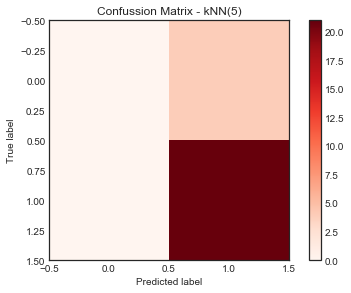

In [190]:
print(classification_report(y_test, knn_model.predict(x_test)))
plot_confussion_matrix('Confussion Matrix - kNN('+ str(best_k) +')', knn_model, x_train, y_train, x_test, y_test)
#plt.savefig('kNN_ConfussionMat.png')

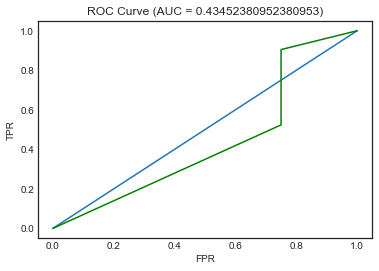

In [191]:
plot_roc_curve(knn_model, x_test, y_test)

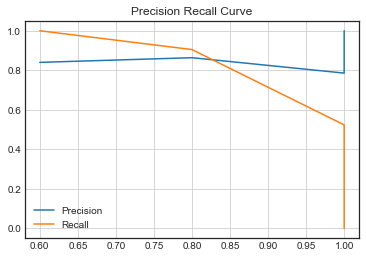

In [192]:
plot_precition_recall(knn_model,x_test, y_test)

In [193]:
knn_model.name='Knn_13_show'
with open("models/inner_knn13_cht.pkl", "wb") as f:
    pickle.dump(knn_model, f)
    
modelos.append(knn_model)

### Logistic Regression (Unbalanced)

In [194]:
log_model = LogisticRegression()
log_model.fit(x_train, y_train)
log_model.score(x_test, y_test)

0.76

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.83      0.90      0.86        21

avg / total       0.69      0.76      0.73        25

Training Data Accuracy: 0.91
Test Data Accuracy:     0.76
[[ 0  4]
 [ 2 19]]


Precision:              0.83
Recall:                 0.90


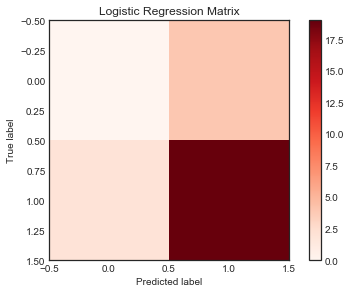

In [195]:
print(classification_report(y_test, log_model.predict(x_test)))
plot_confussion_matrix('Logistic Regression Matrix', log_model, x_train, y_train, x_test, y_test)

**Grid Search**

In [196]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(log_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [197]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=0.00035938136638046257 ........................................
[CV] ......................... C=0.00035938136638046257, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [198]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 0.00035938136638046257}
best score: 0.7931034482758621



In [199]:
log_model = rbf_grid.best_estimator_
log_model.fit(x_train,y_train)
log_model.score(x_test, y_test)

0.84

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.86
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


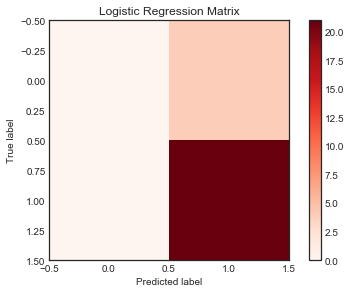

In [200]:
print(classification_report(y_test, log_model.predict(x_test)))
plot_confussion_matrix('Logistic Regression Matrix', log_model, x_train, y_train, x_test, y_test)

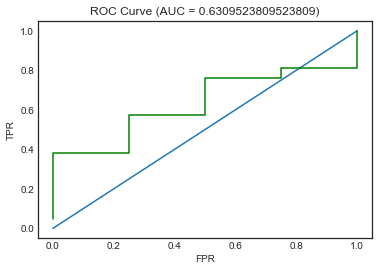

In [201]:
plot_roc_curve(log_model, x_test, y_test)

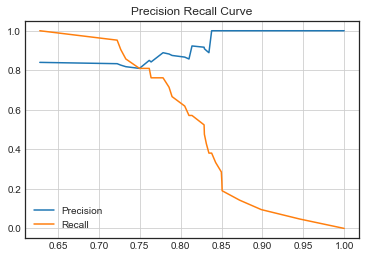

In [202]:
plot_precition_recall(log_model, x_test, y_test)

In [203]:
log_model.name = 'RegLog_show'
with open("models/inner_reglog_cht.pkl", "wb") as f:
    pickle.dump(log_model, f)

modelos.append(log_model)

# Logistic Regression (Balanced)

In [204]:
bal_model = LogisticRegression(class_weight='balanced')
bal_model.fit(x_train, y_train)
bal_model.score(x_test, y_test)

0.68

**Grid Search**

In [205]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(bal_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [206]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] .......................................... C=1e-05, total=   0.0s
[CV] C=1e-05 .........................................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [207]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 0.46415888336127775}
best score: 0.7068965517241379



In [208]:
bal_model = rbf_grid.best_estimator_
bal_model.fit(x_train,y_train)
bal_model.score(x_test, y_test)

0.64

In [209]:
print(classification_report(y_test, bal_model.predict(x_test)))

             precision    recall  f1-score   support

          0       0.14      0.25      0.18         4
          1       0.83      0.71      0.77        21

avg / total       0.72      0.64      0.68        25



Training Data Accuracy: 0.91
Test Data Accuracy:     0.64
[[ 1  3]
 [ 6 15]]


Precision:              0.83
Recall:                 0.71


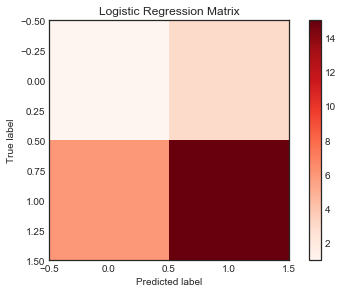

In [210]:
plot_confussion_matrix('Logistic Regression Matrix', bal_model, x_train, y_train, x_test, y_test)

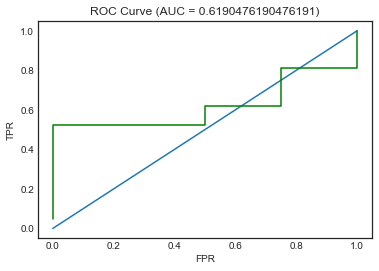

In [211]:
plot_roc_curve(bal_model, x_test, y_test)

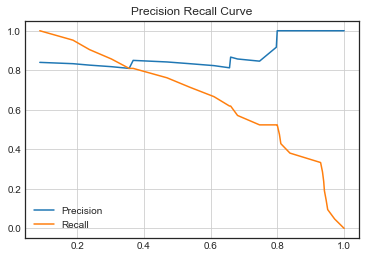

In [212]:
plot_precition_recall(bal_model, x_test, y_test)

In [213]:
bal_model.name = 'LogBal_show'
with open("models/inner_balanced_cht.pkl", "wb") as f:
    pickle.dump(bal_model, f)
modelos.append(bal_model)

## SVM Model (Lineal)

In [214]:
svm_model = svm.SVC(kernel='linear', probability=True)
svm_model.fit(x_train, y_train)
svm_model.score(x_test, y_test)

0.72

**Grid Search**

In [215]:
param_grid = {
    "C": np.logspace(2, -5, 10),
    "gamma": np.logspace(1, -5, 10),
}

rbf_grid = model_selection.RandomizedSearchCV(
    svm_model, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=2)

In [216]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] gamma=10.0, C=0.00035938136638046257 ............................
[CV] ............. gamma=10.0, C=0.00035938136638046257, total=   0.4s
[CV] gamma=10.0, C=0.00035938136638046257 ............................
[CV] ............. gamma=10.0, C=0.00035938136638046257, total=   0.0s
[CV] gamma=10.0, C=0.00035938136638046257 ............................
[CV] ............. gamma=10.0, C=0.00035938136638046257, total=   0.0s
[CV] gamma=10.0, C=0.00035938136638046257 ............................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.4s remaining:    0.0s


[CV] ............. gamma=10.0, C=0.00035938136638046257, total=   0.1s
[CV] gamma=10.0, C=0.00035938136638046257 ............................
[CV] ............. gamma=10.0, C=0.00035938136638046257, total=   0.0s
[CV] gamma=0.1, C=0.0774263682681127 .................................
[CV] .................. gamma=0.1, C=0.0774263682681127, total=   7.0s
[CV] gamma=0.1, C=0.0774263682681127 .................................
[CV] .................. gamma=0.1, C=0.0774263682681127, total=   2.7s
[CV] gamma=0.1, C=0.0774263682681127 .................................
[CV] .................. gamma=0.1, C=0.0774263682681127, total=   6.5s
[CV] gamma=0.1, C=0.0774263682681127 .................................
[CV] .................. gamma=0.1, C=0.0774263682681127, total=   3.8s
[CV] gamma=0.1, C=0.0774263682681127 .................................
[CV] .................. gamma=0.1, C=0.0774263682681127, total=   3.7s


[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:   25.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=2, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [217]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 10.0, 'C': 0.00035938136638046257}
best score: 0.8103448275862069



{'gamma': 10.0, 'C': 0.00035938136638046257}

In [218]:
svm_model = rbf_grid.best_estimator_
svm_model.fit(x_train,y_train)
svm_model.score(x_test, y_test)

0.84

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.84
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


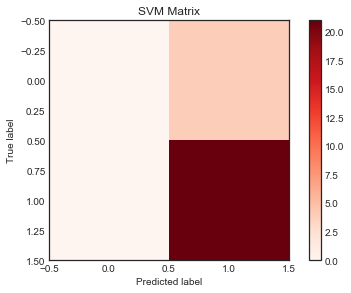

In [219]:
print(classification_report(y_test, svm_model.predict(x_test)))
plot_confussion_matrix('SVM Matrix', svm_model, x_train, y_train, x_test, y_test)

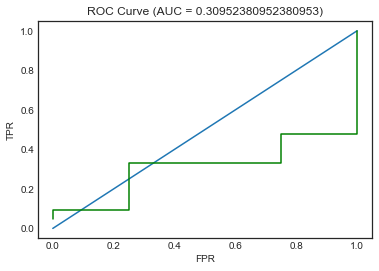

In [220]:
plot_roc_curve(svm_model, x_test, y_test)

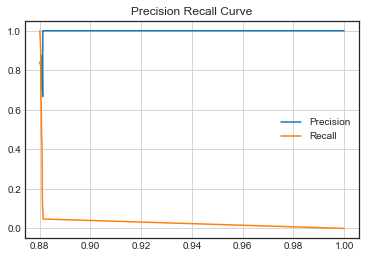

In [221]:
plot_precition_recall(svm_model, x_test, y_test)

In [222]:
svm_model.name = 'svmlin_show'
modelos.append(svm_model)

## SVM Model (RBF Kernell)

In [223]:
rbf_svm = svm.SVC(kernel='rbf', probability=True)
rbf_svm.fit(x_train, y_train)
rbf_svm.score(x_test, y_test)

0.84

In [224]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(rbf_svm, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [225]:
rbf_grid.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ................. gamma=2.154434690031884, C=1e-05, total=   0.0s
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ................. gamma=2.154434690031884, C=1e-05, total=   0.0s
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ................. gamma=2.154434690031884, C=1e-05, total=   0.0s
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ................. gamma=2.154434690031884, C=1e-05, total=   0.0s
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ................. gamma=2.154434690031884, C=1e-05, total=   0.0s
[CV] gamma=10.0, C=5.994842503189409e-05 .............................
[CV] .............. gamma=10.0, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=10.0, C=5.994842503189409e-05 .............................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.0s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [226]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 2.154434690031884, 'C': 1e-05}
best score: 0.8448275862068966



{'gamma': 2.154434690031884, 'C': 1e-05}

In [227]:
rbf_svm = rbf_grid.best_estimator_
rbf_svm.fit(x_train,y_train)
rbf_svm.score(x_test, y_test)

0.84

In [228]:
print(classification_report(y_test, rbf_svm.predict(x_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25



C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training Data Accuracy: 0.84
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


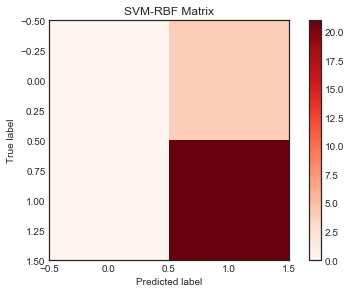

In [229]:
plot_confussion_matrix('SVM-RBF Matrix', rbf_svm, x_train, y_train, x_test, y_test)

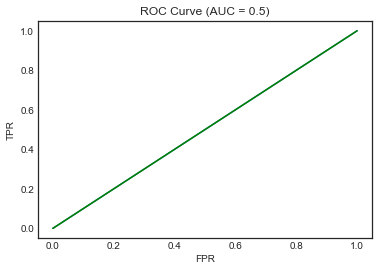

In [230]:
plot_roc_curve(rbf_svm, x_test, y_test)

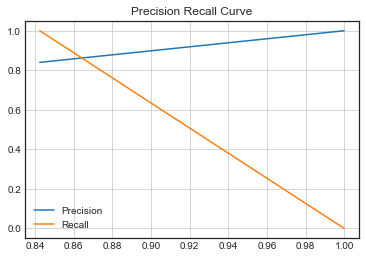

In [231]:
plot_precition_recall(rbf_svm, x_test, y_test)

In [232]:
rbf_svm.name = 'SvmRbf_show'
with open("models/inner_svm_rbf_cht.pkl", "wb") as f:
    pickle.dump(rbf_svm, f)
modelos.append(rbf_svm)

## SVM Model (Polynomial Kernell)

In [233]:
poly_svm = svm.SVC(kernel='poly', probability=True)
poly_svm.fit(x_train, y_train)
poly_svm.score(x_test, y_test)

0.8

**Grid Search**

In [234]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(poly_svm, param_grid, verbose=2, n_jobs=1, cv=3, n_iter=5)

In [235]:
rbf_grid.fit(x_train, y_train)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=2.154434690031884, C=0.01291549665014884 ..................
[CV] ... gamma=2.154434690031884, C=0.01291549665014884, total=   0.0s
[CV] gamma=2.154434690031884, C=0.01291549665014884 ..................
[CV] ... gamma=2.154434690031884, C=0.01291549665014884, total=   0.0s
[CV] gamma=2.154434690031884, C=0.01291549665014884 ..................
[CV] ... gamma=2.154434690031884, C=0.01291549665014884, total=   0.0s
[CV] gamma=0.1, C=5.994842503189409e-05 ..............................
[CV] ............... gamma=0.1, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.1, C=5.994842503189409e-05 ..............................
[CV] ............... gamma=0.1, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=0.1, C=5.994842503189409e-05 ..............................
[CV] ............... gamma=0.1, C=5.994842503189409e-05, total=   0.0s
[CV] gamma=2.154434690031884, C=1e-05 ................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    0.1s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [236]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 4.641588833612782e-05, 'C': 5.994842503189409e-05}
best score: 0.8103448275862069



{'gamma': 4.641588833612782e-05, 'C': 5.994842503189409e-05}

In [237]:
poly_svm = rbf_grid.best_estimator_
poly_svm.fit(x_train,y_train)
poly_svm.score(x_test, y_test)

0.8

In [238]:
print(classification_report(y_test, poly_svm.predict(x_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.83      0.95      0.89        21

avg / total       0.70      0.80      0.75        25



Training Data Accuracy: 0.90
Test Data Accuracy:     0.80
[[ 0  4]
 [ 1 20]]


Precision:              0.83
Recall:                 0.95


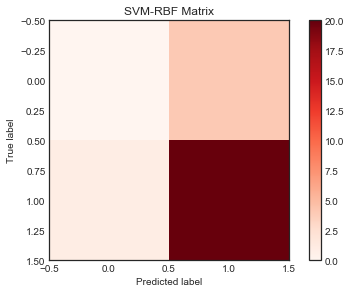

In [239]:
plot_confussion_matrix('SVM-RBF Matrix', poly_svm, x_train, y_train, x_test, y_test)

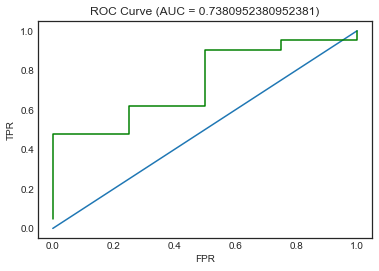

In [240]:
plot_roc_curve(poly_svm, x_test, y_test)

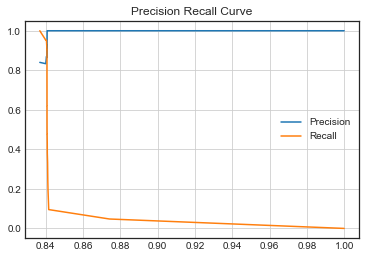

In [241]:
plot_precition_recall(poly_svm, x_test, y_test)

In [242]:
poly_svm.name = 'SvmPoly_show'
modelos.append(poly_svm)

## Decision Tree Model

In [243]:
from sklearn.tree import DecisionTreeClassifier

best_depth = 1
max_score = 0

for d in range(3,50) :
    tree_model = DecisionTreeClassifier(max_depth=d, )
    tree_model.fit(x_train, y_train)
    current_score = accuracy_score(y_test, tree_model.predict(x_test))
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')


Best Depth: 7  (Score = 0.88)


In [244]:
tree_model = DecisionTreeClassifier(max_depth=best_depth)
tree_model.fit(x_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [245]:
print(classification_report(y_test, tree_model.predict(x_test)))

             precision    recall  f1-score   support

          0       1.00      0.25      0.40         4
          1       0.88      1.00      0.93        21

avg / total       0.90      0.88      0.85        25



Training Data Accuracy: 0.98
Test Data Accuracy:     0.88
[[ 1  3]
 [ 0 21]]


Precision:              0.88
Recall:                 1.00


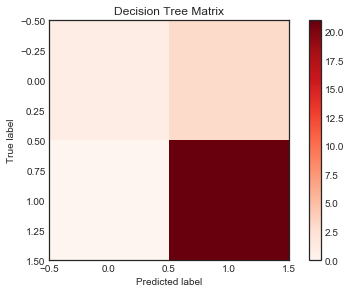

In [246]:
plot_confussion_matrix('Decision Tree Matrix', tree_model, x_train, y_train, x_test, y_test)

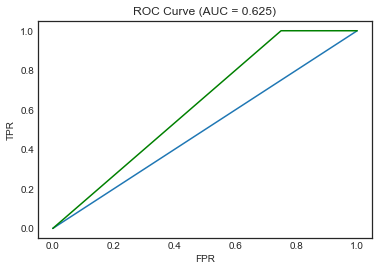

In [247]:
plot_roc_curve(tree_model, x_test, y_test)

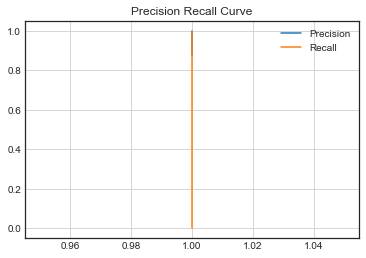

In [248]:
plot_precition_recall(tree_model, x_test, y_test)

In [249]:
tree_model.name = 'tree_show'
modelos.append(tree_model)

In [250]:
with open("models/inner_tree_cht.pkl", "wb") as f:
    pickle.dump(tree_model, f)

## Random Forest Model

In [251]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 1
max_score = 0

for d in range(1,50) :
    forest_model = RandomForestClassifier(max_depth=d, max_features=None, n_estimators=30)
    forest_model.fit(x_train, y_train)
    #current_score = accuracy_score(y_test, forest_model.predict(x_test))
    current_score = forest_model.score(x_test,y_test)
    if current_score > max_score :
        max_score = current_score
        best_depth = d
        best_model = forest_model
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')

Best Depth: 1  (Score = 0.84)


In [252]:
forest_model = best_model
#forest_model = RandomForestClassifier(max_depth=best_depth, max_features=None, n_estimators=30)
#forest_model.fit(x_train, y_train)
#forest_model.score(x_test,y_test)

In [253]:
print(classification_report(y_test, forest_model.predict(x_test)))

             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25



C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Training Data Accuracy: 0.88
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


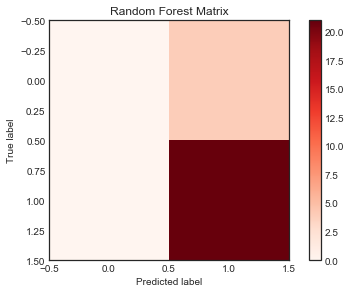

In [254]:
plot_confussion_matrix('Random Forest Matrix', forest_model, x_train, y_train, x_test, y_test)

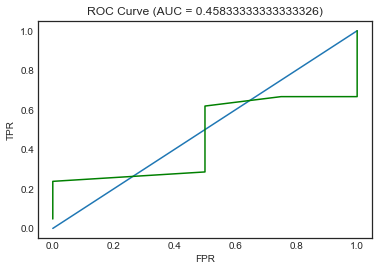

In [255]:
plot_roc_curve(forest_model, x_test, y_test)

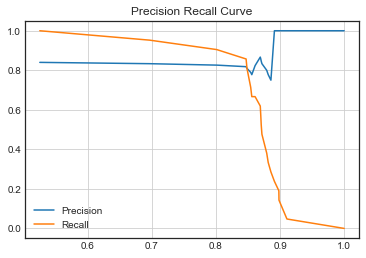

In [256]:
plot_precition_recall(forest_model, x_test, y_test)

In [257]:
forest_model.name = 'forest_show'
with open("models/inner_forest_cht.pkl", "wb") as f:
    pickle.dump(forest_model, f)
modelos.append(forest_model)

## Naive Bayes Model

In [258]:
from sklearn import naive_bayes, metrics

gauss_model = naive_bayes.GaussianNB()
gauss_model.fit(x_train, y_train)
gauss_model.score(x_test,y_test)

0.72

             precision    recall  f1-score   support

          0       0.33      0.75      0.46         4
          1       0.94      0.71      0.81        21

avg / total       0.84      0.72      0.75        25

Training Data Accuracy: 0.88
Test Data Accuracy:     0.72
[[ 3  1]
 [ 6 15]]


Precision:              0.94
Recall:                 0.71


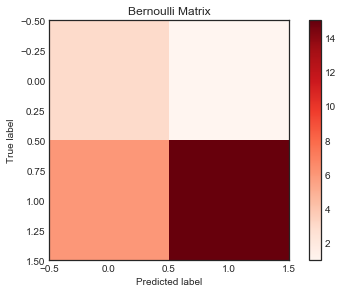

In [259]:
y_pred = gauss_model.predict(x_test)
print(metrics.classification_report(y_test, y_pred))
plot_confussion_matrix('Bernoulli Matrix', gauss_model, x_train, y_train, x_test, y_test)

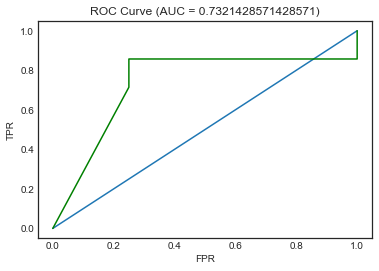

In [260]:
plot_roc_curve(gauss_model, x_test, y_test)

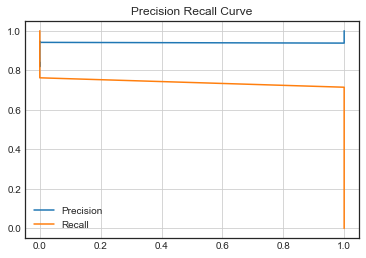

In [261]:
plot_precition_recall(gauss_model, x_test, y_test)

In [262]:
gauss_model.name = 'gaussNB_show'
modelos.append(gauss_model)

No good.  

### Try Naiver Bayes - Bernoulli, but only with Binary variables

In [263]:
x_bin = got_df[['isdead_bk', 'ismale', 'book1', 'book2', 'book3', 'book4', 'book5',
            #'isalivemother_bk', 'isalivefather_bk', 'isaliveheir_bk','isalivespouse_bk', 'ismarried_bk', 
            'isnoble_bk', 'booldeadrelations_bk', 'ispopular_bk', #'death_bk', 'apperance_chp',
            #'hasmom_bk', 'hasdad_bk', 'hasheir_bk', 'hasspouse_bk', 
            #'age_bk', 'numdeadrelations_bk', 'popularity_bk', 
            #'culture_bk', 'house_bk', 'name_y', 'isalive_shw', 'death_season', 
            #'time_s1', 'time_s2', 'time_s3', 'time_s4', 'total_episode_num', 
            'season1', 'season2', 'season3', 'season4', #'age_shw', #'house_shw', 'match_name',
            'culture_bk[T.Astap]', 'culture_bk[T.Braav]', 'culture_bk[T.Crann]', 'culture_bk[T.Dorni]', 
            'culture_bk[T.Dothr]', 'culture_bk[T.Free ]', 'culture_bk[T.Ghisc]', 'culture_bk[T.Ironb]', 
            'culture_bk[T.Ironm]', 'culture_bk[T.Lhaza]', 'culture_bk[T.Lysen]', 'culture_bk[T.Myris]', 
            'culture_bk[T.Naath]', 'culture_bk[T.None]', 'culture_bk[T.North]', 'culture_bk[T.Pento]', 
            'culture_bk[T.Qarth]', 'culture_bk[T.Reach]', 'culture_bk[T.River]', 'culture_bk[T.Storm]', 
            'culture_bk[T.The R]', 'culture_bk[T.Tyros]', 'culture_bk[T.Valem]', 'culture_bk[T.Valyr]', 
            'culture_bk[T.Weste]', 'culture_bk[T.Wildl]',
            'house_bk[T.BROTHERHOOD WITHOUT BANNERS]', 'house_bk[T.HOUSE ARRYN]', 'house_bk[T.HOUSE BAELISH]', 
            'house_bk[T.HOUSE BARATHEON]', 'house_bk[T.HOUSE BOLTON]', 'house_bk[T.HOUSE CLEGANE]', 
            'house_bk[T.HOUSE FREY]', 'house_bk[T.HOUSE GREYJOY]', 'house_bk[T.HOUSE LANNISTER]', 
            'house_bk[T.HOUSE MARTELL]', 'house_bk[T.HOUSE STARK]', 'house_bk[T.HOUSE TARGARYEN]', 
            'house_bk[T.HOUSE TULLY]', 'house_bk[T.HOUSE TYRELL]', 'house_bk[T.NIGHTS WATCH]', 'house_bk[T.OTHER]', 
            'house_bk[T.UNKNOWN]', 'house_shw[T.House Bolton]', 'house_shw[T.House Greyjoy]', 
            'house_shw[T.House Lannister]', 'house_shw[T.House Stark]', 'house_shw[T.House Targaryen]', 
            'house_shw[T.None]', 'house_shw[T.Nights Watch]']]

In [264]:
x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x_bin, y, test_size=0.30, random_state=4444, stratify=y)

In [265]:
bern_model = naive_bayes.BernoulliNB()
bern_model.fit(x_train2, y_train2)
bern_model.score(x_test2,y_test2)

0.84

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\metrics\classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


             precision    recall  f1-score   support

          0       0.00      0.00      0.00         4
          1       0.84      1.00      0.91        21

avg / total       0.71      0.84      0.77        25

Training Data Accuracy: 0.88
Test Data Accuracy:     0.84
[[ 0  4]
 [ 0 21]]


Precision:              0.84
Recall:                 1.00


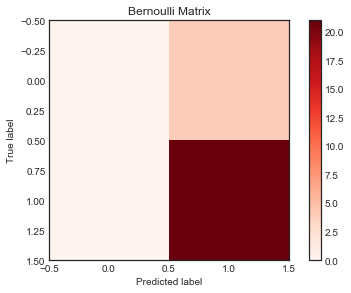

In [266]:
y_pred = bern_model.predict(x_test2)
print(metrics.classification_report(y_test2, y_pred))
plot_confussion_matrix('Bernoulli Matrix', bern_model, x_train2, y_train2, x_test2, y_test2)

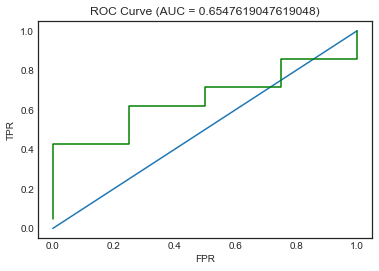

In [267]:
plot_roc_curve(bern_model, x_test2, y_test2)

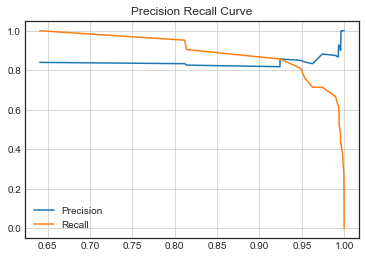

In [268]:
plot_precition_recall(bern_model, x_test2, y_test2)

In [269]:
#bern_model.name = 'bernoulNB_show'
#modelos.append(bern_model)

> So far, best Model is **RANDOM FOREST**

# Analysis on LEFT JOIN
**All Characters from the books, including those with info from Tv Show**

In [270]:
got_df = pd.read_csv('csv/SQL_GOT_data.csv')
total = len(got_df)
total

2011

In [271]:
deads6_list = ['Grenn', 'Janos Slynt', 'Doreah', 'Mace Tyrell', 'Brynden Tully', 'Xaro Xhoan Daxos', 'Kevan Lannister']
got_df['isdead_shw'][got_df['name_x'].isin(deads6_list)] = 1

alive_list = ['Cersei Lannister', 'Tyrion Lannister', 'Daenerys Targaryen', 'Arya Stark', 'Jorah Mormont', 
              #'Jon Snow', 'Brienne of Tarth', 'Bronn', #Estos registros sí cambiaron en S7
              'Sansa Stark', 'Jaime Lannister', 'Samwell Tarly', 'Sandor Clegane', 'Varys', 'Brandon Stark',
              'Theon Greyjoy', 'Podrick Payne', 'Missandei', 'Eddison Tollett', 'Grey Worm', 'Gendry', 'Davos Seaworth',
              'Melisandre', 'Gilly', 'Meera Reed', 'Daario Naharis', 'Hot Pie', 'Gregor Clegane', 'Qyburn', 'Anguy', 
              "Jaqen H'ghar", 'Ellaria Sand', 'Brynden Tully', 'Beric Dondarrion', 'Xaro Xhoan Daxos', 'Salladhor Saan']
got_df = got_df[got_df['name_x'].isin(alive_list)==False]
len(got_df)

C:\Users\mramirbe\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


1979

In [272]:
y = got_df['isdead_shw']
x = got_df[x_test.columns]
len(x)

1979

In [273]:
print('Original dataset shape {}'.format(Counter(y)))

x_train2, x_test2, y_train2, y_test2 = model_selection.train_test_split(x, y, test_size=0.30, random_state=4444, stratify=y)
print('Original dataset train {}'.format(Counter(y_train2)))
print('Original dataset test {}'.format(Counter(y_test2)))

Original dataset shape Counter({0.0: 1909, 1.0: 70})
Original dataset train Counter({0.0: 1336, 1.0: 49})
Original dataset test Counter({0.0: 573, 1.0: 21})


### kNN Model

In [274]:
best_k = 1
max_score = 0

for k in range(1,51) :
    model = KNeighborsClassifier(k)
    model.fit(x_train2, y_train2)
    current_score = accuracy_score(y_test2, model.predict(x_test2))
    if current_score > max_score :
        max_score = current_score
        best_k = k
print('Best k: ' + str(best_k) + '  (Score = ' + str(max_score) + ')')


Best k: 3  (Score = 0.98989898989899)


In [275]:
knn_model_bk = KNeighborsClassifier(best_k)
knn_model_bk.fit(x_train2, y_train2)
knn_model_bk.score(x_test2, y_test2)

0.98989898989899

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       573
        1.0       0.80      0.95      0.87        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.99
[[568   5]
 [  1  20]]


Precision:              0.80
Recall:                 0.95


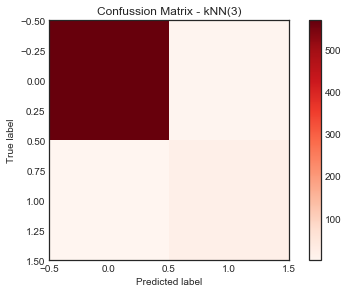

In [276]:
print(classification_report(y_test2, knn_model_bk.predict(x_test2)))
plot_confussion_matrix('Confussion Matrix - kNN('+ str(best_k) +')', knn_model_bk, x_train2, y_train2, x_test2, y_test2)
#plt.savefig('kNN_ConfussionMat.png')

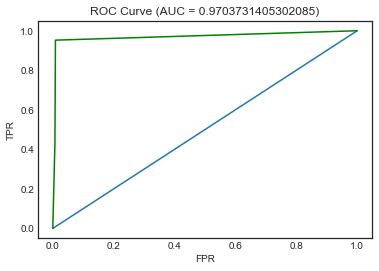

In [277]:
plot_roc_curve(knn_model_bk, x_test2, y_test2)

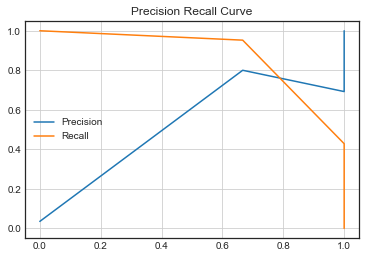

In [278]:
plot_precition_recall(knn_model_bk, x_test2, y_test2)

In [279]:
knn_model_bk.name = 'knn_bk2'
with open("models/left_knn6_cht.pkl", "wb") as f:
    pickle.dump(knn_model_bk, f)
modelos.append(knn_model_bk)

### Logistic Regression (Unbalanced)

In [280]:
log_model_bk = LogisticRegression()
log_model_bk.fit(x_train2, y_train2)
log_model_bk.score(x_test2, y_test2)

0.9797979797979798

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.76      0.62      0.68        21

avg / total       0.98      0.98      0.98       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.98
[[569   4]
 [  8  13]]


Precision:              0.76
Recall:                 0.62


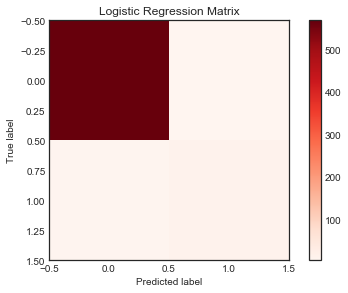

In [281]:
print(classification_report(y_test2, log_model_bk.predict(x_test2)))
plot_confussion_matrix('Logistic Regression Matrix', log_model_bk, x_train2, y_train2, x_test2, y_test2)

**Grid Search**

In [282]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(log_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [283]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.002154434690031882 ..........................................
[CV] ........................... C=0.002154434690031882, total=   0.0s
[CV] C=0.0774263682681127 ............................................
[CV] ............................. C=0.0774263682681127, total=   0.0s
[CV] C=0.0774263682681127 ............................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................. C=2.7825594022071245, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............................. C=2.7825594022071245, total=   0.0s
[CV] C=2.7825594022071245 ............................................
[CV] ............................. C=2.7825594022071245, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [284]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 100.0}
best score: 0.9855595667870036



In [285]:
log_model_bk = rbf_grid.best_estimator_
log_model_bk.fit(x_train2, y_train2)
log_model_bk.score(x_test2, y_test2)

0.9865319865319865

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.81      0.81      0.81        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[569   4]
 [  4  17]]


Precision:              0.81
Recall:                 0.81


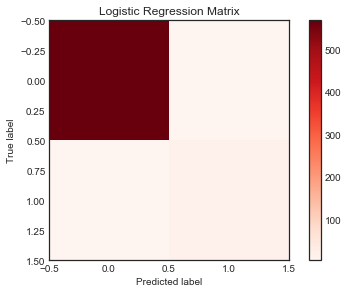

In [286]:
print(classification_report(y_test2, log_model_bk.predict(x_test2)))
plot_confussion_matrix('Logistic Regression Matrix', log_model_bk, x_train2, y_train2, x_test2, y_test2)

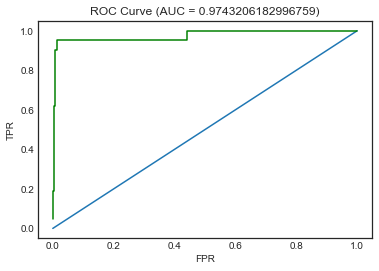

In [287]:
plot_roc_curve(log_model_bk, x_test2, y_test2)

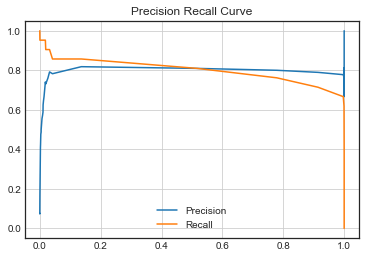

In [288]:
plot_precition_recall(log_model_bk, x_test2, y_test2)

In [289]:
log_model_bk.name = 'RegLog_bk2'
with open("models/left_reglog_cht.pkl", "wb") as f:
    pickle.dump(log_model_bk, f)
modelos.append(log_model_bk)

# Logistic Regression (Balanced)

In [290]:
bal_model_bk = LogisticRegression(class_weight='balanced')
bal_model_bk.fit(x_train2, y_train2)
bal_model_bk.score(x_test2, y_test2)

0.9865319865319865

**Grid Search**

In [291]:
param_grid = {
    "C": np.logspace(2,-5,10)
}

rbf_grid = model_selection.RandomizedSearchCV(bal_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [292]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=100.0 .........................................................
[CV] .......................................... C=100.0, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=0.46415888336127775 ...........................................
[CV] ............................ C=0.46415888336127775, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .......................... C=5.994842503189409e-05, total=   0.0s
[CV] C=5.994842503189409e-05 .........................................
[CV] .

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    0.3s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=LogisticRegression(C=1.0, class_weight='balanced', dual=False,
          fit_intercept=True, intercept_scaling=1, max_iter=100,
          multi_class='ovr', n_jobs=1, penalty='l2', random_state=None,
          solver='liblinear', tol=0.0001, verbose=0, warm_start=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [293]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")


best params: {'C': 1e-05}
best score: 0.9927797833935018



In [294]:
bal_model_bk = rbf_grid.best_estimator_
bal_model_bk.fit(x_train2,y_train2)
bal_model_bk.score(x_test2, y_test2)

0.9915824915824916

In [295]:
print(classification_report(y_test2, bal_model_bk.predict(x_test2)))

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       573
        1.0       0.81      1.00      0.89        21

avg / total       0.99      0.99      0.99       594



Training Data Accuracy: 0.99
Test Data Accuracy:     0.99
[[568   5]
 [  0  21]]


Precision:              0.81
Recall:                 1.00


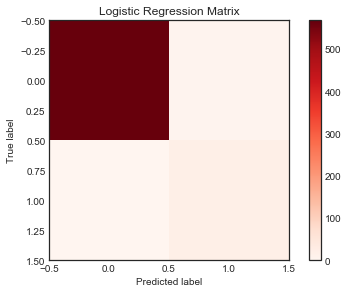

In [296]:
plot_confussion_matrix('Logistic Regression Matrix', bal_model_bk, x_train2, y_train2, x_test2, y_test2)

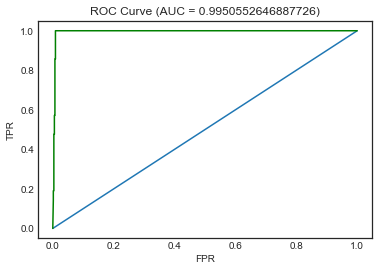

In [297]:
plot_roc_curve(bal_model_bk, x_test2, y_test2)

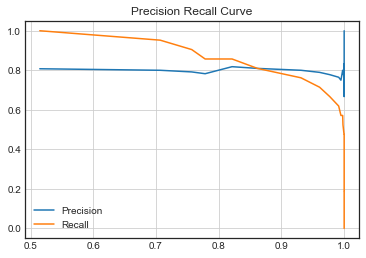

In [298]:
plot_precition_recall(bal_model_bk, x_test2, y_test2)

In [299]:
bal_model_bk.name='RegLogBal_bk2'
with open("models/left_balanced_cht.pkl", "wb") as f:
    pickle.dump(bal_model_bk, f)
modelos.append(bal_model_bk)

## SVM Model (Lineal)

In [300]:
svm_model_bk = svm.SVC(kernel='linear', probability=True)
svm_model_bk.fit(x_train2, y_train2)
svm_model_bk.score(x_test2, y_test2)

0.9865319865319865

**Grid Search**

In [301]:
param_grid = {
    "C": np.logspace(2, -5, 10),
    "gamma": np.logspace(1, -5, 10),
}

rbf_grid = model_selection.RandomizedSearchCV(
    svm_model_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=2)

In [302]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 2 candidates, totalling 10 fits
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total= 1.1min
[CV] gamma=0.1, C=0.46415888336127775 ................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  1.1min remaining:    0.0s


[CV] ................. gamma=0.1, C=0.46415888336127775, total=   2.7s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total= 1.1min
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total= 1.4min
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total= 1.1min
[CV] gamma=0.004641588833612782, C=0.0774263682681127 ................
[CV] . gamma=0.004641588833612782, C=0.0774263682681127, total=  17.5s
[CV] gamma=0.004641588833612782, C=0.0774263682681127 ................
[CV] . gamma=0.004641588833612782, C=0.0774263682681127, total=   1.2s
[CV] gamma=0.004641588833612782, C=0.0774263682681127 ................
[CV] . gamma=0.004641588833612782, C=0.0774263682681127, total=  18.7s
[CV] gamma=0.004641588833612782, C=0.0774263682681127 ................
[CV] .

[Parallel(n_jobs=1)]: Done  10 out of  10 | elapsed:  5.9min finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='linear',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=2, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [303]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.004641588833612782, 'C': 0.0774263682681127}
best score: 0.9870036101083033



{'gamma': 0.004641588833612782, 'C': 0.0774263682681127}

In [304]:
svm_model_bk = rbf_grid.best_estimator_
svm_model_bk.fit(x_train2,y_train2)
svm_model_bk.score(x_test2, y_test2)

0.9865319865319865

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.81      0.81      0.81        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.99
[[569   4]
 [  4  17]]


Precision:              0.81
Recall:                 0.81


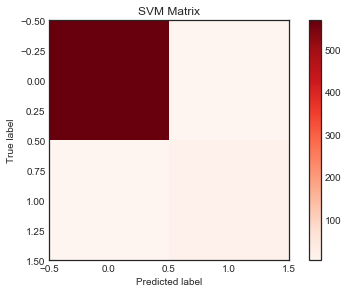

In [305]:
print(classification_report(y_test2, svm_model_bk.predict(x_test2)))
plot_confussion_matrix('SVM Matrix', svm_model_bk, x_train2, y_train2, x_test2, y_test2)

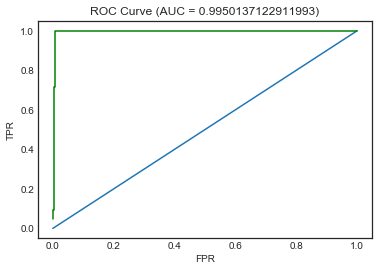

In [306]:
plot_roc_curve(svm_model_bk, x_test2, y_test2)

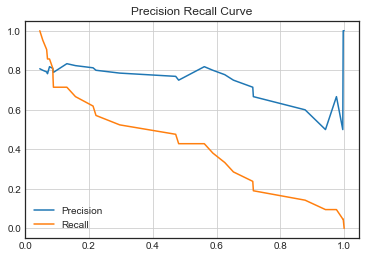

In [307]:
plot_precition_recall(svm_model_bk, x_test2, y_test2)

In [308]:
svm_model_bk.name = 'SvmLin_bk2'
modelos.append(svm_model_bk)

## SVM Model (RBF Kernell)

In [309]:
rbf_svm_bk = svm.SVC(kernel='rbf', probability=True)
rbf_svm_bk.fit(x_train2, y_train2)
rbf_svm_bk.score(x_test2, y_test2)

0.98989898989899

In [310]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(rbf_svm_bk, param_grid, verbose=2, n_jobs=1, cv=5, n_iter=5)

In [311]:
rbf_grid.fit(x_train2, y_train2)

Fitting 5 folds for each of 5 candidates, totalling 25 fits
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.0s remaining:    0.0s


[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=0.00021544346900318867, C=0.46415888336127775 .............
[CV]  gamma=0.00021544346900318867, C=0.46415888336127775, total=   0.0s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s
[CV] gamma=2.154434690031884, C=0.002154434690031882 .................
[C

[Parallel(n_jobs=1)]: Done  25 out of  25 | elapsed:    6.9s finished


RandomizedSearchCV(cv=5, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='rbf',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [312]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.00021544346900318867, 'C': 0.46415888336127775}
best score: 0.9942238267148015



{'gamma': 0.00021544346900318867, 'C': 0.46415888336127775}

In [313]:
rbf_svm_bk = rbf_grid.best_estimator_
rbf_svm_bk.fit(x_train2,y_train2)
rbf_svm_bk.score(x_test2, y_test2)

0.9915824915824916

             precision    recall  f1-score   support

        0.0       1.00      0.99      1.00       573
        1.0       0.81      1.00      0.89        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 0.99
Test Data Accuracy:     0.99
[[568   5]
 [  0  21]]


Precision:              0.81
Recall:                 1.00


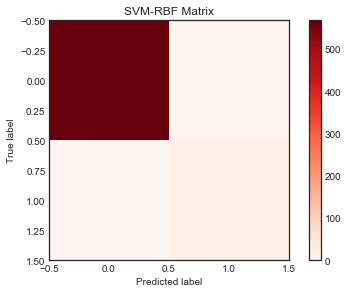

In [314]:
print(classification_report(y_test2, rbf_svm_bk.predict(x_test2)))
plot_confussion_matrix('SVM-RBF Matrix', rbf_svm_bk, x_train2, y_train2, x_test2, y_test2)

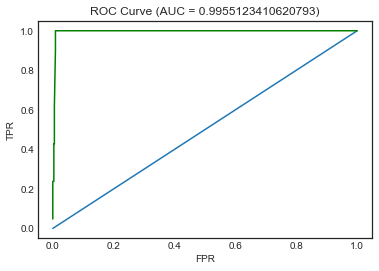

In [315]:
plot_roc_curve(rbf_svm_bk, x_test2, y_test2)

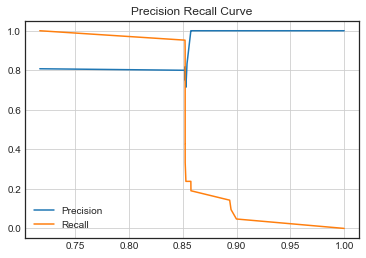

In [316]:
plot_precition_recall(rbf_svm_bk, x_test2, y_test2)

In [317]:
rbf_svm_bk.name = 'SvmRbf_bk2'
with open("models/left_svm_rbf_cht.pkl", "wb") as f:
    pickle.dump(rbf_svm_bk, f)
    modelos.append(rbf_svm_bk)

## SVM Model (Polynomial Kernell)

In [318]:
svm_poly_bk = svm.SVC(kernel='poly', probability=True)
svm_poly_bk.fit(x_train2, y_train2)
svm_poly_bk.score(x_test2, y_test2)

0.9848484848484849

**Grid Search**

In [319]:
param_grid = {
    "C": np.logspace(2,-5,10),
    "gamma": np.logspace(1,-5,10),
}

rbf_grid = model_selection.RandomizedSearchCV(svm_poly_bk, param_grid, verbose=2, n_jobs=1, cv=3, n_iter=5)

In [320]:
rbf_grid.fit(x_train2, y_train2)

Fitting 3 folds for each of 5 candidates, totalling 15 fits
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   1.5s
[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.1s

[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.5s remaining:    0.0s



[CV] gamma=0.1, C=0.46415888336127775 ................................
[CV] ................. gamma=0.1, C=0.46415888336127775, total=   0.0s
[CV] gamma=4.641588833612782e-05, C=1e-05 ............................
[CV] ............. gamma=4.641588833612782e-05, C=1e-05, total=   0.0s
[CV] gamma=4.641588833612782e-05, C=1e-05 ............................
[CV] ............. gamma=4.641588833612782e-05, C=1e-05, total=   0.0s
[CV] gamma=4.641588833612782e-05, C=1e-05 ............................
[CV] ............. gamma=4.641588833612782e-05, C=1e-05, total=   0.0s
[CV] gamma=0.021544346900318846, C=0.0774263682681127 ................
[CV] . gamma=0.021544346900318846, C=0.0774263682681127, total=   0.9s
[CV] gamma=0.021544346900318846, C=0.0774263682681127 ................
[CV] . gamma=0.021544346900318846, C=0.0774263682681127, total=   0.1s
[CV] gamma=0.021544346900318846, C=0.0774263682681127 ................
[CV] . gamma=0.021544346900318846, C=0.0774263682681127, total=   0.0s
[CV] 

[Parallel(n_jobs=1)]: Done  15 out of  15 | elapsed:    6.6s finished


RandomizedSearchCV(cv=3, error_score='raise',
          estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
  decision_function_shape='ovr', degree=3, gamma='auto', kernel='poly',
  max_iter=-1, probability=True, random_state=None, shrinking=True,
  tol=0.001, verbose=False),
          fit_params=None, iid=True, n_iter=5, n_jobs=1,
          param_distributions={'C': array([1.00000e+02, 1.66810e+01, 2.78256e+00, 4.64159e-01, 7.74264e-02,
       1.29155e-02, 2.15443e-03, 3.59381e-04, 5.99484e-05, 1.00000e-05]), 'gamma': array([1.00000e+01, 2.15443e+00, 4.64159e-01, 1.00000e-01, 2.15443e-02,
       4.64159e-03, 1.00000e-03, 2.15443e-04, 4.64159e-05, 1.00000e-05])},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=2)

In [321]:
print(f"""
best params: {rbf_grid.best_params_}
best score: {rbf_grid.best_score_}
""")
rbf_grid.best_params_


best params: {'gamma': 0.1, 'C': 0.46415888336127775}
best score: 0.9877256317689531



{'gamma': 0.1, 'C': 0.46415888336127775}

In [322]:
svm_poly_bk = rbf_grid.best_estimator_
svm_poly_bk.fit(x_train2,y_train2)
svm_poly_bk.score(x_test2, y_test2)

0.9848484848484849

             precision    recall  f1-score   support

        0.0       0.99      0.99      0.99       573
        1.0       0.77      0.81      0.79        21

avg / total       0.99      0.98      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.98
[[568   5]
 [  4  17]]


Precision:              0.77
Recall:                 0.81


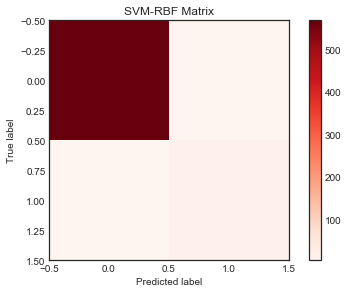

In [323]:
print(classification_report(y_test2, svm_poly_bk.predict(x_test2)))
plot_confussion_matrix('SVM-RBF Matrix', svm_poly_bk, x_train2, y_train2, x_test2, y_test2)

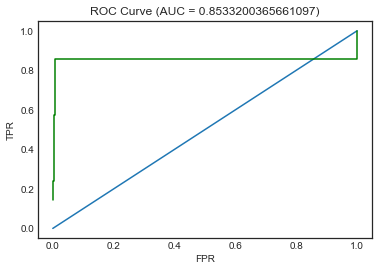

In [324]:
plot_roc_curve(svm_poly_bk, x_test2, y_test2)

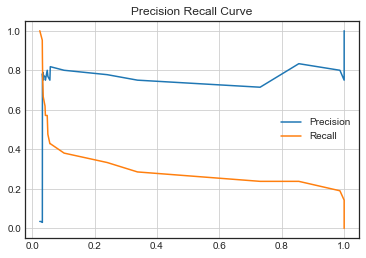

In [325]:
plot_precition_recall(svm_poly_bk, x_test2, y_test2)

In [326]:
svm_poly_bk.name = 'SvmPoly_bk2'
modelos.append(svm_poly_bk)

## Decision Tree Model

In [327]:
from sklearn.tree import DecisionTreeClassifier

best_depth = 1
max_score = 0

for d in range(3,50) :
    tree_model_bk = DecisionTreeClassifier(max_depth=d, )
    tree_model_bk.fit(x_train2, y_train2)
    current_score = accuracy_score(y_test2, tree_model_bk.predict(x_test2))
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')


Best Depth: 17  (Score = 0.9915824915824916)


In [328]:
tree_model_bk = DecisionTreeClassifier(max_depth=best_depth)
tree_model_bk.fit(x_train2, y_train2)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=17,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       573
        1.0       0.83      0.90      0.86        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[569   4]
 [  2  19]]


Precision:              0.83
Recall:                 0.90


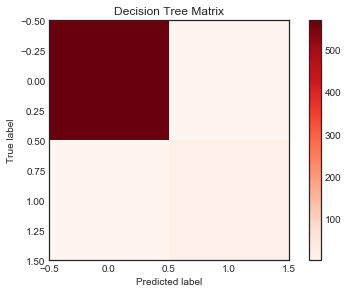

In [329]:
print(classification_report(y_test2, tree_model_bk.predict(x_test2)))
plot_confussion_matrix('Decision Tree Matrix', tree_model_bk, x_train2, y_train2, x_test2, y_test2)

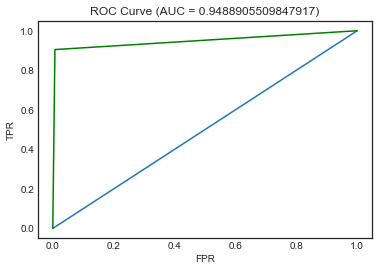

In [330]:
plot_roc_curve(tree_model_bk, x_test2, y_test2)

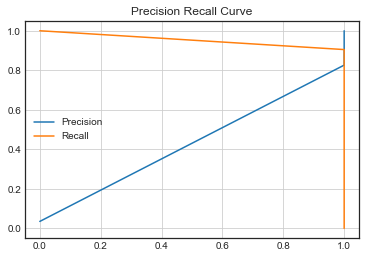

In [331]:
sns.set_style("white")
plot_precition_recall(tree_model_bk, x_test2, y_test2)

In [332]:
tree_model_bk.name = 'DecTree_bk'
modelos.append(tree_model_bk)

## Random Forest Model

In [333]:
from sklearn.ensemble import RandomForestClassifier

best_depth = 1
max_score = 0

for d in range(1,50) :
    forest_model_bk = RandomForestClassifier(max_depth=d, max_features=None, n_estimators=30)
    forest_model_bk.fit(x_train2, y_train2)
    #current_score = accuracy_score(y_test2, forest_model_bk.predict(x_test2))
    current_score = forest_model_bk.score(x_test2,y_test2)
    if current_score > max_score :
        max_score = current_score
        best_depth = d
print('Best Depth: ' + str(best_depth) + '  (Score = ' + str(max_score) + ')')

Best Depth: 24  (Score = 0.9932659932659933)


In [334]:
forest_model_bk = RandomForestClassifier(max_depth=best_depth, max_features=None, n_estimators=30)
forest_model_bk.fit(x_train2, y_train2)
forest_model_bk.score(x_test2,y_test2)

0.98989898989899

             precision    recall  f1-score   support

        0.0       1.00      0.99      0.99       573
        1.0       0.80      0.95      0.87        21

avg / total       0.99      0.99      0.99       594

Training Data Accuracy: 1.00
Test Data Accuracy:     0.99
[[568   5]
 [  1  20]]


Precision:              0.80
Recall:                 0.95


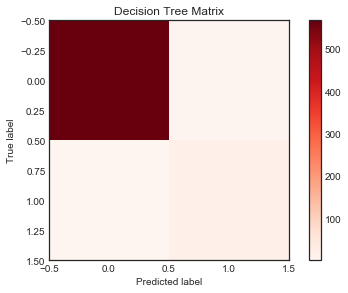

In [335]:
print(classification_report(y_test2, forest_model_bk.predict(x_test2)))
plot_confussion_matrix('Decision Tree Matrix', forest_model_bk, x_train2, y_train2, x_test2, y_test2)

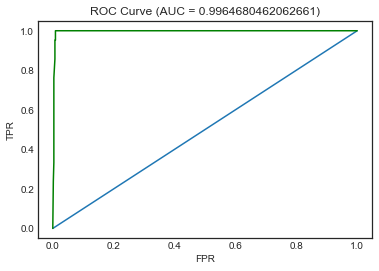

In [336]:
plot_roc_curve(forest_model_bk, x_test2, y_test2)

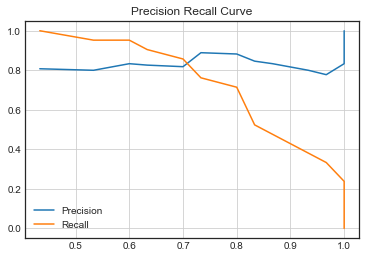

In [337]:
plot_precition_recall(forest_model_bk, x_test2, y_test2)

In [338]:
forest_model_bk.name = 'Forest_bk2'
modelos.append(forest_model_bk)

In [339]:
sorted(zip(x.columns, forest_model_bk.feature_importances_), key=lambda tup: tup[1], reverse=True)
zipped = sorted(zip(x.columns, forest_model_bk.feature_importances_), key=lambda tup: tup[1], reverse=True)
zipped

[('season2', 0.2543792235867549),
 ('time_s2', 0.2262536689020926),
 ('season1', 0.10049437749400571),
 ('time_s3', 0.0967859979100646),
 ('time_s1', 0.0912691445182052),
 ('time_s4', 0.08389898574032785),
 ('season3', 0.04534967602111717),
 ('season4', 0.03418798164197864),
 ('popularity_bk', 0.011123441150908991),
 ('book2', 0.007548105546014888),
 ('ismale', 0.00571471689454851),
 ('age_bk', 0.004710013519378295),
 ('house_bk[T.HOUSE TYRELL]', 0.004546363740457602),
 ('culture_bk[T.Valem]', 0.004122651316530582),
 ('house_shw[T.House Stark]', 0.004070960381409595),
 ('culture_bk[T.North]', 0.003997451213714973),
 ('culture_bk[T.Pento]', 0.003115193369372424),
 ('house_shw[T.House Bolton]', 0.0026872467569327954),
 ('culture_bk[T.Braav]', 0.0021552294282528653),
 ('house_bk[T.HOUSE ARRYN]', 0.0016967555748720567),
 ('culture_bk[T.Ghisc]', 0.0016281673935433475),
 ('book5', 0.0015497677553958083),
 ('house_bk[T.OTHER]', 0.0014833290824394136),
 ('isdead_bk', 0.001444513612066257),
 ('

([], <a list of 0 Text xticklabel objects>)

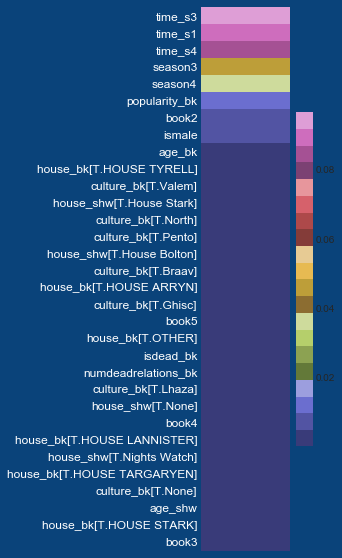

In [340]:
sns.set_style("dark")
fig = plt.figure(figsize=(2, 10))
fig.patch.set_facecolor('xkcd:twilight blue')
important_val = pd.DataFrame(j for i,j in zipped[3:] if j>0)
important_col = pd.DataFrame(i for i,j in zipped[3:] if j>0)
                             
sns.heatmap(important_val, yticklabels=important_col[0], cmap='tab20b')
plt.yticks(fontsize=12, color='white')
plt.xticks([])

In [341]:
with open("models/left_forest_cht.pkl", "wb") as f:
    pickle.dump(forest_model_bk, f)

## Graficarlas todas

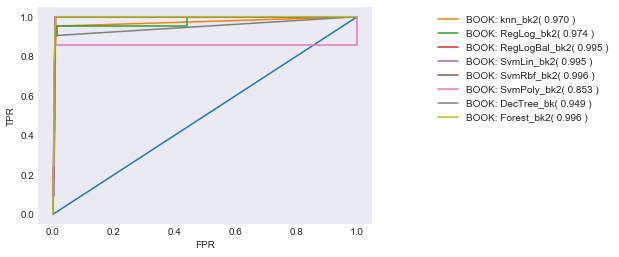

In [342]:
plt.figure()
ax = plt.subplot(111)

# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

# for model in modelos[:9] :
#     y_score=model.predict_proba(x_test)[:,1]
#     fpr, tpr,_ = roc_curve(y_test, y_score)
#     roc_auc = auc(fpr, tpr)
#     plt.plot(fpr,tpr, label='SHOW: '+model.name+ '( %0.3f' %(roc_auc) +' )')
# ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

for model in modelos[9:] :
    y_score2=model.predict_proba(x_test2)[:,1]
    fpr, tpr,_ = roc_curve(y_test2, y_score2)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='BOOK: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

### Solo las que sirven:

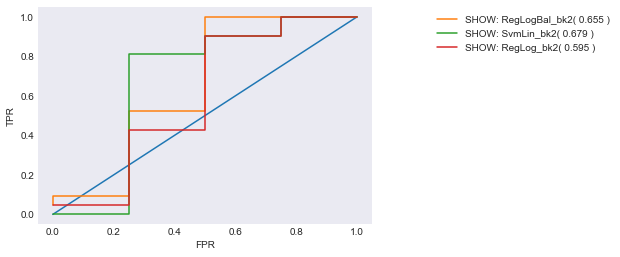

In [343]:
good_models = [bal_model_bk, svm_model_bk, log_model_bk]#, forest_model_bk]#rbf_svm_bk]
plt.figure()
ax = plt.subplot(111)

# Plotting our Baseline..
plt.plot([0,1],[0,1])
plt.xlabel('FPR')
plt.ylabel('TPR')

for model in good_models[:3] :
    y_score=model.predict_proba(x_test)[:,1]
    fpr, tpr,_ = roc_curve(y_test, y_score)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='SHOW: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)

for model in good_models[3:] :
    y_score2=model.predict_proba(x_test2)[:,1]
    fpr, tpr,_ = roc_curve(y_test2, y_score2)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr,tpr, label='BOOK: '+model.name+ '( %0.3f' %(roc_auc) +' )')
ax.legend(loc='upper center', bbox_to_anchor=(1.45, 1), shadow=True, ncol=1)


In [344]:
coef_df = pd.DataFrame()

for model in good_models :
    print(model.name)
    coef_list = sorted(zip(x.columns, model.coef_[0]), key=lambda tup: tup[1], reverse=True)
    if (len(coef_df) == 0) :
        coef_df = pd.DataFrame(coef_list)
    else :
        coef_df = pd.merge(coef_df, pd.DataFrame(coef_list), how='inner', on=0)
    coef_df.rename(columns={1:model.name}, inplace=True)
coef_df.rename(columns={0:'Feature'}, inplace=True)
coef_df.index=coef_df['Feature']
coef_df.drop('Feature', axis=1, inplace=True)
coef_df

RegLogBal_bk2
SvmLin_bk2
RegLog_bk2


,RegLogBal_bk2,SvmLin_bk2,RegLog_bk2
Feature,,,
time_s2,1.302912e-02,0.001815,-0.013623
time_s1,8.055017e-03,0.000960,0.004066
time_s3,7.091023e-03,0.000454,-0.009193
time_s4,6.977258e-03,0.000958,-0.000408
numdeadrelations_bk,2.234151e-04,-0.000706,-0.150400
season2,1.938860e-04,0.732653,16.136265
season1,1.435268e-04,0.344729,4.587604
season4,1.258935e-04,0.270943,5.600827
ispopular_bk,1.230075e-04,-0.020192,1.151735


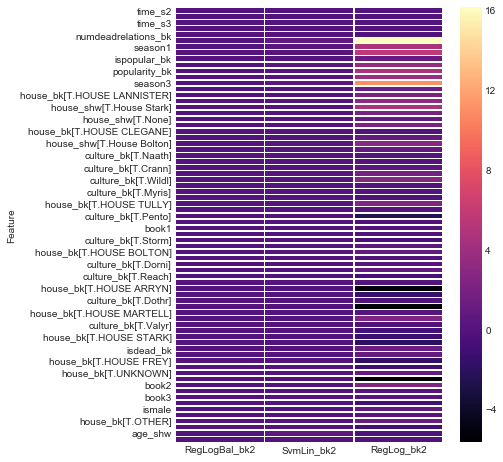

In [346]:
plt.subplots(figsize=(6, 8))
sns.heatmap(coef_df, annot=False, linewidths=.5, cmap='magma')